In [1]:
import sys

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval
from scipy.stats import pointbiserialr
import networkx as nx
from sklearn.cross_decomposition import PLSCanonical

from scipy.stats import pearsonr

In [2]:
corrdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = corrdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = corrdict['eeg_partial_correlation144x2']       
intervals144                    = corrdict['intervals144']                       
samples144                      = corrdict['samples144']                         
session144                      = corrdict['session144']      

In [3]:
eeg_partial_correlation144x2 = eeg_partial_correlation144x2.astype(bool)

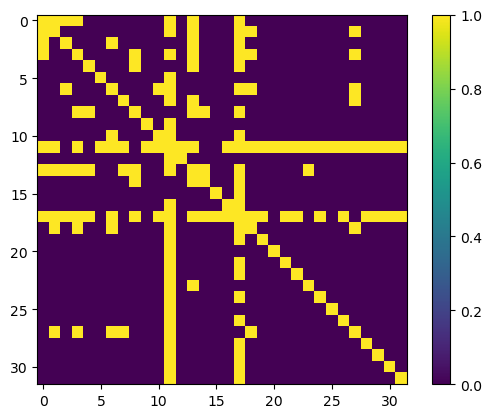

In [5]:
plt.imshow(eeg_partial_correlation144x2[143,1,6,:,:]) # motor areas are disconnected from the rest of the brain. No connections detected from motor areas.
plt.colorbar()

In [4]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
from hdf5storage import loadmat,savemat

In [5]:
# compute networkx
dg_ctr144=np.zeros((144,2,7,32))
efficiency144=np.zeros((144,2,7,32))
bw_ctr144=np.zeros((144,2,7,32))

for f in range(144):
    for syn in range(2):
        for freq in range(7):
            mat=eeg_partial_correlation144x2[f,syn,freq,:,:]
            mat[range(mat.shape[0]),range(mat.shape[0])]=0 # reomve the self-connection in th
            G= nx.from_numpy_array(mat)
            dg_ctr=nx.degree_centrality(G)
            bw_ctr=nx.betweenness_centrality(G)

            for chan in range(32):
                dg_ctr144[f,syn,freq,chan]=dg_ctr[chan]
                bw_ctr144[f,syn,freq,chan]=bw_ctr[chan]

                dict_values=nx.single_source_shortest_path(G,chan).values()
                list_values=list(len(value)-1 for value in dict_values)
                list_values.pop(0)
                list_values=[1 / val for val in list_values]
                efficiency144[f,syn,freq,chan]=np.sum(list_values)/(32-1)


In [8]:
outdict=dict()
outdict['dg_ctr144']    =dg_ctr144
outdict['efficiency144']=efficiency144
outdict['bw_ctr144']    =bw_ctr144

savemat('nx144',outdict)

In [11]:
outdict=loadmat('nx144.mat')
dg_ctr144       =outdict['dg_ctr144']    
efficiency144   =outdict['efficiency144']
bw_ctr144       =outdict['bw_ctr144']    

In [6]:
hurstdict = loadmat('H.mat')
hurstdict.keys()
H= hurstdict['H']
H.shape

(144, 2)

In [7]:
indices=loadmat('Indicies.mat')
syn2_condi4_ind     = indices['syn2_condi4_ind']
indices.keys()

dict_keys(['L_lead_ind', 'L_lead_synch_ind', 'L_lead_synco_ind', 'Mutual_ind', 'Mutual_synch_ind', 'Mutual_synco_ind', 'R_lead_ind', 'R_lead_synch_ind', 'R_lead_synco_ind', 'Uncoupled_ind', 'Uncoupled_synch_ind', 'Uncoupled_synco_ind', 'condi4_ind', 'syn2_condi4_ind', 'syn_ind', 'synch_condi4_ind', 'synch_ind', 'synco_condi4_ind', 'synco_ind'])

In [8]:
#organize hurst exponents 
H_follow_synco  = np.zeros(36)
H_lead_synco    = np.zeros(36)
H_ind_synco     = np.zeros(36)
H_mutual_synco  = np.zeros(36)
H_follow_synch  = np.zeros(36)
H_lead_synch    = np.zeros(36)
H_ind_synch     = np.zeros(36)
H_mutual_synch  = np.zeros(36)

H_follow_synco[0:18]    = H[indices['R_lead_synco_ind'],0]
H_follow_synco[18:36]   = H[indices['L_lead_synco_ind'],1]
H_lead_synco[0:18]      = H[indices['L_lead_synco_ind'],0]
H_lead_synco[18:36]     = H[indices['R_lead_synco_ind'],1]
H_mutual_synco[0:18]    = H[indices['Mutual_synco_ind'],0] 
H_mutual_synco[18:36]   = H[indices['Mutual_synco_ind'],1]
H_ind_synco[0:18]       = H[indices['Uncoupled_synco_ind'],0]
H_ind_synco[18:36]      = H[indices['Uncoupled_synco_ind'],1]

H_follow_synch[0:18]    = H[indices['R_lead_synch_ind'],0]
H_follow_synch[18:36]   = H[indices['L_lead_synch_ind'],1]
H_lead_synch[0:18]      = H[indices['L_lead_synch_ind'],0]
H_lead_synch[18:36]     = H[indices['R_lead_synch_ind'],1]
H_mutual_synch[0:18]    = H[indices['Mutual_synch_ind'],0]
H_mutual_synch[18:36]   = H[indices['Mutual_synch_ind'],1]
H_ind_synch[0:18]       = H[indices['Uncoupled_synch_ind'],0]
H_ind_synch[18:36]      = H[indices['Uncoupled_synch_ind'],1]

# organized into np
H_synch=[H_ind_synch, H_lead_synch, H_follow_synch, H_mutual_synch]
H_synco=[H_ind_synco, H_lead_synco, H_follow_synco, H_mutual_synco]
H_syn=[H_synch, H_synco]

In [19]:
H_Lall = H[:,0]
H_Rall = H[:,1]
H1over = 1 - np.abs(H_Lall - H_Rall) / (H_Lall + H_Rall)

In [21]:
#organize hurst exponents 
H1over_follow_synco = np.zeros(36)
H1over_lead_synco = np.zeros(36)
H1over_ind_synco = np.zeros(36)
H1over_mutual_synco = np.zeros(36)
H1over_follow_synch = np.zeros(36)
H1over_lead_synch = np.zeros(36)
H1over_ind_synch = np.zeros(36)
H1over_mutual_synch = np.zeros(36)

H1over_follow_synco[0:18]    = H1over[indices['R_lead_synco_ind']]
H1over_follow_synco[18:36]   = H1over[indices['L_lead_synco_ind']]
H1over_lead_synco[0:18]      = H1over[indices['L_lead_synco_ind']]
H1over_lead_synco[18:36]     = H1over[indices['R_lead_synco_ind']]
H1over_mutual_synco[0:18]    = H1over[indices['Mutual_synco_ind']] 
H1over_mutual_synco[18:36]   = H1over[indices['Mutual_synco_ind']]
H1over_ind_synco[0:18]       = H1over[indices['Uncoupled_synco_ind']]
H1over_ind_synco[18:36]      = H1over[indices['Uncoupled_synco_ind']]

H1over_follow_synch[0:18]    = H1over[indices['R_lead_synch_ind']]
H1over_follow_synch[18:36]   = H1over[indices['L_lead_synch_ind']]
H1over_lead_synch[0:18]      = H1over[indices['L_lead_synch_ind']]
H1over_lead_synch[18:36]     = H1over[indices['R_lead_synch_ind']]
H1over_mutual_synch[0:18]    = H1over[indices['Mutual_synch_ind']] 
H1over_mutual_synch[18:36]   = H1over[indices['Mutual_synch_ind']]
H1over_ind_synch[0:18]       = H1over[indices['Uncoupled_synch_ind']]
H1over_ind_synch[18:36]      = H1over[indices['Uncoupled_synch_ind']]

# organized into np
H1over_synch =[H1over_ind_synch, H1over_lead_synch, H1over_follow_synch, H1over_mutual_synch]
H1over_synco =[H1over_ind_synco, H1over_lead_synco, H1over_follow_synco, H1over_mutual_synco]
H1over_syn   =[H1over_synch, H1over_synco]

In [12]:
# dg_ctr144=np.zeros((144,2,7,32))
dgctr_follow_synco  = np.zeros((36,7,32))
dgctr_lead_synco    = np.zeros((36,7,32))
dgctr_ind_synco     = np.zeros((36,7,32))
dgctr_mutual_synco  = np.zeros((36,7,32))
dgctr_follow_synch  = np.zeros((36,7,32))
dgctr_lead_synch    = np.zeros((36,7,32))
dgctr_ind_synch     = np.zeros((36,7,32))
dgctr_mutual_synch  = np.zeros((36,7,32))
dgctr_follow_synco[0:18,:,:]  = dg_ctr144[indices['R_lead_synco_ind'],0,:,:]
dgctr_follow_synco[18:36,:,:] = dg_ctr144[indices['L_lead_synco_ind'],1,:,:]
dgctr_lead_synco[0:18,:,:]    = dg_ctr144[indices['L_lead_synco_ind'],0,:,:]
dgctr_lead_synco[18:36,:,:]   = dg_ctr144[indices['R_lead_synco_ind'],1,:,:]
dgctr_mutual_synco[0:18,:,:]  = dg_ctr144[indices['Mutual_synco_ind'],0,:,:] 
dgctr_mutual_synco[18:36,:,:] = dg_ctr144[indices['Mutual_synco_ind'],1,:,:]
dgctr_ind_synco[0:18,:,:]     = dg_ctr144[indices['Uncoupled_synco_ind'],0,:,:]
dgctr_ind_synco[18:36,:,:]    = dg_ctr144[indices['Uncoupled_synco_ind'],1,:,:]
dgctr_follow_synch[0:18,:,:]  = dg_ctr144[indices['R_lead_synch_ind'],0,:,:]
dgctr_follow_synch[18:36,:,:] = dg_ctr144[indices['L_lead_synch_ind'],1,:,:]
dgctr_lead_synch[0:18,:,:]    = dg_ctr144[indices['L_lead_synch_ind'],0,:,:]
dgctr_lead_synch[18:36,:,:]   = dg_ctr144[indices['R_lead_synch_ind'],1,:,:]
dgctr_mutual_synch[0:18,:,:]  = dg_ctr144[indices['Mutual_synch_ind'],0,:,:] 
dgctr_mutual_synch[18:36,:,:] = dg_ctr144[indices['Mutual_synch_ind'],1,:,:]
dgctr_ind_synch[0:18,:,:]     = dg_ctr144[indices['Uncoupled_synch_ind'],0,:,:]
dgctr_ind_synch[18:36,:,:]    = dg_ctr144[indices['Uncoupled_synch_ind'],1,:,:]

# organized into np array (edges)
dgctr_synch =[dgctr_ind_synch, dgctr_lead_synch, dgctr_follow_synch, dgctr_mutual_synch]
dgctr_synco =[dgctr_ind_synco, dgctr_lead_synco, dgctr_follow_synco, dgctr_mutual_synco]
dgctr_syn   =[dgctr_synch, dgctr_synco]

In [13]:
# efficiency144=np.zeros((144,2,7,32))
effi_follow_synco  = np.zeros((36,7,32))
effi_lead_synco    = np.zeros((36,7,32))
effi_ind_synco     = np.zeros((36,7,32))
effi_mutual_synco  = np.zeros((36,7,32))
effi_follow_synch  = np.zeros((36,7,32))
effi_lead_synch    = np.zeros((36,7,32))
effi_ind_synch     = np.zeros((36,7,32))
effi_mutual_synch  = np.zeros((36,7,32))
effi_follow_synco[0:18,:,:]  = efficiency144[indices['R_lead_synco_ind'],0,:,:]
effi_follow_synco[18:36,:,:] = efficiency144[indices['L_lead_synco_ind'],1,:,:]
effi_lead_synco[0:18,:,:]    = efficiency144[indices['L_lead_synco_ind'],0,:,:]
effi_lead_synco[18:36,:,:]   = efficiency144[indices['R_lead_synco_ind'],1,:,:]
effi_mutual_synco[0:18,:,:]  = efficiency144[indices['Mutual_synco_ind'],0,:,:] 
effi_mutual_synco[18:36,:,:] = efficiency144[indices['Mutual_synco_ind'],1,:,:]
effi_ind_synco[0:18,:,:]     = efficiency144[indices['Uncoupled_synco_ind'],0,:,:]
effi_ind_synco[18:36,:,:]    = efficiency144[indices['Uncoupled_synco_ind'],1,:,:]
effi_follow_synch[0:18,:,:]  = efficiency144[indices['R_lead_synch_ind'],0,:,:]
effi_follow_synch[18:36,:,:] = efficiency144[indices['L_lead_synch_ind'],1,:,:]
effi_lead_synch[0:18,:,:]    = efficiency144[indices['L_lead_synch_ind'],0,:,:]
effi_lead_synch[18:36,:,:]   = efficiency144[indices['R_lead_synch_ind'],1,:,:]
effi_mutual_synch[0:18,:,:]  = efficiency144[indices['Mutual_synch_ind'],0,:,:] 
effi_mutual_synch[18:36,:,:] = efficiency144[indices['Mutual_synch_ind'],1,:,:]
effi_ind_synch[0:18,:,:]     = efficiency144[indices['Uncoupled_synch_ind'],0,:,:]
effi_ind_synch[18:36,:,:]    = efficiency144[indices['Uncoupled_synch_ind'],1,:,:]

# organized into np array (edges)
effi_synch =[effi_ind_synch, effi_lead_synch, effi_follow_synch, effi_mutual_synch]
effi_synco =[effi_ind_synco, effi_lead_synco, effi_follow_synco, effi_mutual_synco]
effi_syn   =[effi_synch, effi_synco]

In [14]:
# bw_ctr144=np.zeros((144,2,7,32))
bwctr_follow_synco  = np.zeros((36,7,32))
bwctr_lead_synco    = np.zeros((36,7,32))
bwctr_ind_synco     = np.zeros((36,7,32))
bwctr_mutual_synco  = np.zeros((36,7,32))
bwctr_follow_synch  = np.zeros((36,7,32))
bwctr_lead_synch    = np.zeros((36,7,32))
bwctr_ind_synch     = np.zeros((36,7,32))
bwctr_mutual_synch  = np.zeros((36,7,32))
bwctr_follow_synco[0:18,:,:]  = bw_ctr144[indices['R_lead_synco_ind'],0,:,:]
bwctr_follow_synco[18:36,:,:] = bw_ctr144[indices['L_lead_synco_ind'],1,:,:]
bwctr_lead_synco[0:18,:,:]    = bw_ctr144[indices['L_lead_synco_ind'],0,:,:]
bwctr_lead_synco[18:36,:,:]   = bw_ctr144[indices['R_lead_synco_ind'],1,:,:]
bwctr_mutual_synco[0:18,:,:]  = bw_ctr144[indices['Mutual_synco_ind'],0,:,:] 
bwctr_mutual_synco[18:36,:,:] = bw_ctr144[indices['Mutual_synco_ind'],1,:,:]
bwctr_ind_synco[0:18,:,:]     = bw_ctr144[indices['Uncoupled_synco_ind'],0,:,:]
bwctr_ind_synco[18:36,:,:]    = bw_ctr144[indices['Uncoupled_synco_ind'],1,:,:]
bwctr_follow_synch[0:18,:,:]  = bw_ctr144[indices['R_lead_synch_ind'],0,:,:]
bwctr_follow_synch[18:36,:,:] = bw_ctr144[indices['L_lead_synch_ind'],1,:,:]
bwctr_lead_synch[0:18,:,:]    = bw_ctr144[indices['L_lead_synch_ind'],0,:,:]
bwctr_lead_synch[18:36,:,:]   = bw_ctr144[indices['R_lead_synch_ind'],1,:,:]
bwctr_mutual_synch[0:18,:,:]  = bw_ctr144[indices['Mutual_synch_ind'],0,:,:] 
bwctr_mutual_synch[18:36,:,:] = bw_ctr144[indices['Mutual_synch_ind'],1,:,:]
bwctr_ind_synch[0:18,:,:]     = bw_ctr144[indices['Uncoupled_synch_ind'],0,:,:]
bwctr_ind_synch[18:36,:,:]    = bw_ctr144[indices['Uncoupled_synch_ind'],1,:,:]

# organized into np array (edges)
bwctr_synch =[bwctr_ind_synch, bwctr_lead_synch, bwctr_follow_synch, bwctr_mutual_synch]
bwctr_synco =[bwctr_ind_synco, bwctr_lead_synco, bwctr_follow_synco, bwctr_mutual_synco]
bwctr_syn   =[bwctr_synch, bwctr_synco]

In [15]:
# organize the 3 networkx
cc3_syn=np.zeros((3,2,4,36,7,32)) # 3 
cc3_syn[0,:,:,:,:,:]=dgctr_syn
cc3_syn[1,:,:,:,:,:]=effi_syn
cc3_syn[2,:,:,:,:,:]=bwctr_syn


In [16]:
outdict=dict()
outdict['cc3_syn']    =cc3_syn
savemat('cc3_syn',outdict)

In [22]:
# real correlation (nodes)
r_ccH=np.zeros((3,2,4,7,32))
p_ccH=np.zeros((3,2,4,7,32))
for ccc in range(3):
    for syn in range(2):
        for st in range(4):
            for freq in range(7):
                for chan in range(32):
                    r_ccH[ccc,syn,st,freq,chan],p_ccH[ccc,syn,st,freq,chan]= pearsonr(
                        cc3_syn[ccc,syn,st,:,freq,chan],H1over_syn[syn][st])

In [ ]:
            mat=eeg_partial_correlation144x2[f,syn,freq,:,:]
            mat[range(mat.shape[0]),range(mat.shape[0])]=0 # reomve the self-connection in th
            G= nx.from_numpy_array(mat)
            dg_ctr=nx.degree_centrality(G)
            bw_ctr=nx.betweenness_centrality(G)

            for chan in range(32):
                dg_ctr144[f,syn,freq,chan]=dg_ctr[chan]
                bw_ctr144[f,syn,freq,chan]=bw_ctr[chan]

                dict_values=nx.single_source_shortest_path(G,chan).values()
                list_values=list(len(value)-1 for value in dict_values)
                list_values.pop(0)
                list_values=[1 / val for val in list_values]
                efficiency144[f,syn,freq,chan]=np.sum(list_values)/(32-1)

In [27]:
# # This step takes hours, output was saved already, can skip to save time
# simulate 36 random network to get a correlation then repeat 100 times (nodes)
r100_4crH1over=np.zeros((100,3,2,4,7,32)) # Distribution
for r in range(100):
    # construct 36 random network with matched number of edges
    cr3_syn=np.zeros((2,4,7,36,3,32)) # 36 random graph
    for syn in range(2):
        for st in range(4): # all condition
            for tr in range(36):
                for freq in range(7):
                    mat=eeg_partial_correlation144x2[f,syn,freq,:,:]
                    mat[range(mat.shape[0]),range(mat.shape[0])]=0 # reomve the self-connection in th
                    G= nx.from_numpy_array(mat)
                    nEdges = len(G.edges())
                    R=nx.gnm_random_graph(32, nEdges, seed=None, directed=False)
                    dg_ctr=nx.degree_centrality(R)
                    bw_ctr=nx.betweenness_centrality(R)

                    xr=np.zeros((3,32))

                    for chan in range(32):
                        xr[0,chan]=dg_ctr[chan]
                        xr[1,chan]=bw_ctr[chan]

                        dict_values=nx.single_source_shortest_path(R,chan).values()
                        list_values=list(len(value)-1 for value in dict_values)
                        list_values.pop(0)
                        list_values=[1 / val for val in list_values]
                        xr[2,chan]=np.sum(list_values)/(32-1)

                    cr3_syn[syn,st,freq,tr,:,:]=xr

    # compute correlation
    r_crH=np.zeros((3,2,4,7,32))
    p_crH=np.zeros((3,2,4,7,32))
    for ccc in range(3):
        for syn in range(2):
            for st in range(4):
                for freq in range(7):
                    for chan in range(32):
                        r_crH[ccc,syn,st,freq,chan],p_crH[ccc,syn,st,freq,chan]= pearsonr(
                            cr3_syn[syn,st,freq,:,ccc,chan],H1over_syn[syn][st])
                    r100_4crH1over[r,ccc,syn,st,freq,:]=r_crH[ccc,syn,st,freq,:]
    print(r)
# 2h x 4 st = 8 h
outdict = dict()
outdict['r100_4crH1over']       = r100_4crH1over
savemat('r100_4crH1over',outdict,store_python_metadata = True) 

# This is going to take at least a day

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
# Did not try

# To speed up this long-running simulation with parallel computing in Python, 
# you can use joblib or concurrent.futures to parallelize the outer loop (for r in range(100):) since each iteration is independent.
# Here’s a clean adaptation using joblib.Parallel, which is ideal for this case:

import numpy as np
import networkx as nx
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from scipy.io import savemat

def process_single_simulation(r, eeg_partial_correlation144x2, H1over_syn):
    r_crH = np.zeros((3,2,4,7,32))
    cr3_syn = np.zeros((2,4,7,36,3,32))  # syn, st, freq, tr, centrality_type, chan

    for syn in range(2):
        for st in range(4):
            for tr in range(36):
                for freq in range(7):
                    mat = eeg_partial_correlation144x2[tr, syn, freq, :, :]
                    np.fill_diagonal(mat, 0)  # remove self-connections
                    G = nx.from_numpy_array(mat)
                    nEdges = len(G.edges())
                    R = nx.gnm_random_graph(32, nEdges, seed=None, directed=False)

                    dg_ctr = nx.degree_centrality(R)
                    bw_ctr = nx.betweenness_centrality(R)

                    xr = np.zeros((3,32))
                    for chan in range(32):
                        xr[0, chan] = dg_ctr[chan]
                        xr[1, chan] = bw_ctr[chan]

                        paths = nx.single_source_shortest_path(R, chan).values()
                        lengths = [len(p)-1 for p in paths if len(p) > 1]
                        inv_lengths = [1 / l for l in lengths]
                        xr[2, chan] = np.sum(inv_lengths) / (32 - 1)

                    cr3_syn[syn, st, freq, tr, :, :] = xr

    r_out = np.zeros((3,2,4,7,32))
    for ccc in range(3):
        for syn in range(2):
            for st in range(4):
                for freq in range(7):
                    for chan in range(32):
                        try:
                            corr, _ = pearsonr(cr3_syn[syn, st, freq, :, ccc, chan], H1over_syn[syn][st])
                        except Exception:
                            corr = np.nan
                        r_out[ccc, syn, st, freq, chan] = corr
    return r_out


# Assuming eeg_partial_correlation144x2 and H1over_syn are preloaded
n_jobs = -1  # use all CPUs
results = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(process_single_simulation)(r, eeg_partial_correlation144x2, H1over_syn) for r in range(100)
)

# Convert list of arrays to a single numpy array
r100_4crH1over = np.stack(results, axis=0)  # shape: [100, 3, 2, 4, 7, 32]

# Save result
savemat('r100_4crH1over.mat', {'r100_4crH1over': r100_4crH1over}, store_python_metadata=True)


In [ ]:
outdict=loadmat('r100_4crH1over.mat')
r100_4crH1over  = outdict['r100_4crH1over']

In [28]:
# z-score estimate (nodes)
zscore_crH=np.zeros((3,2,4,7,32))
for ccc in range(3):
    for syn in range(2):
        for st in range(4): # only for mutual
            for freq in range(7):
                for chan in range(32):
                    crH_distri_random=r100_4crH1over[:,ccc,syn,st,freq,chan]
                    r_crH_real=r_ccH[ccc,syn,st,freq,chan]
                    r_distri_random=[r_crH_real]+crH_distri_random.tolist()
                    zscores=stats.zscore(r_distri_random)
                    zscore_crH[ccc,syn,st,freq,chan]=zscores[0]

In [29]:
# Save result
savemat('zscore_crH1over.mat', {'zscore_crH': zscore_crH})